In [57]:
!pip install --upgrade numpy torch

  Using cached torch-2.4.1-cp311-cp311-win_amd64.whl.metadata (27 kB)
Using cached torch-2.4.1-cp311-cp311-win_amd64.whl (199.4 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
darts 0.30.0 requires numpy<2.0.0,>=1.19.0, but you have numpy 2.1.1 which is incompatible.
nbeats-pytorch 1.8.0 requires protobuf<=3.20, but you have protobuf 4.25.4 which is incompatible.
torchaudio 2.0.0+cu118 requires torch==2.0.0, but you have torch 2.4.1 which is incompatible.
torchvision 0.15.0+cu118 requires torch==2.0.0, but you have torch 2.4.1 which is incompatible.


C:\Users\admin\AppData\Local\Temp\ipykernel_2644\1775746677.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_transaction = df.resample('H').size()  # Hourly transaction count


Epoch 0/100, Loss: 0.0020034725557790574
Epoch 10/100, Loss: 0.0014593403697240278
Epoch 20/100, Loss: 0.0013114264688279412
Epoch 30/100, Loss: 0.00125226713829127
Epoch 40/100, Loss: 0.0011859762164873045
Epoch 50/100, Loss: 0.0011283978387294764
Epoch 60/100, Loss: 0.0011001051181431757
Epoch 70/100, Loss: 0.001083143387062458
Epoch 80/100, Loss: 0.0010799678424885924
Epoch 90/100, Loss: 0.0010364635778353933
Test Loss: 0.0020571404063418784
Test predictions saved to C:\Users\admin\Desktop\airline\metro ridership project\metro_ridership_prediction\output of sensors\test_predictions.csv


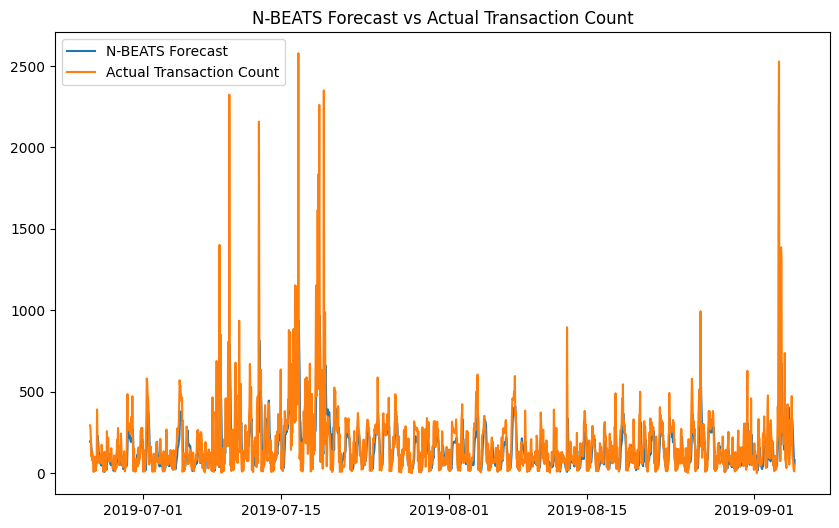

Mean Squared Error: 34478.11963425069
Mean Absolute Error: 96.16501846038443
R-Squared: 0.31629035369208336
Model saved to C:\Users\admin\Desktop\airline\metro ridership project\metro_ridership_prediction\output of sensors\nbeats_model.pth


In [63]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Load Dataset
df = pd.read_csv('AFC.3_74_objEvent.csv')  # Use your dataset

# Data Preprocessing
df['Dt'] = pd.to_datetime(df['Dt'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

# Drop rows with invalid dates if needed
df = df.dropna(subset=['Dt'])

# Set the index to the date column
df.set_index('Dt', inplace=True)

# Aggregating the Transaction Count at Hourly Level
hourly_transaction = df.resample('H').size()  # Hourly transaction count

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(hourly_transaction.values.reshape(-1, 1))

# Hyperparameters
LOOKBACK = 24  # Backcast horizon (input sequence length)
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.00001
DROPOUT_RATE = 0.2  # Dropout rate

# Prepare the data for training
def create_sequences(data, lookback):
    x, y = [], []
    for i in range(len(data) - lookback):
        x.append(data[i : i + lookback])
        y.append(data[i + lookback])  # Predicting the next hour
    return np.array(x), np.array(y)

# Split the dataset into training and testing
split_idx = int(len(scaled_data) * 0.8)
train_series, test_series = scaled_data[:split_idx], scaled_data[split_idx:]

# Create sequences for training and testing
X_train, y_train = create_sequences(train_series, LOOKBACK)
X_test, y_test = create_sequences(test_series, LOOKBACK)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Updated N-BEATS Model Definition with Dropout
class NBeatsModel(nn.Module):
    def __init__(self, input_size, hidden_dim=256, dropout_rate=0.2):
        super(NBeatsModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout layer after first hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout layer after second hidden layer
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)  # Additional hidden layer
        self.dropout3 = nn.Dropout(dropout_rate)  # Dropout layer after third hidden layer
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input: [batch_size, LOOKBACK] 
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout
        x = torch.relu(self.fc3(x))  # Apply ReLU activation to the additional hidden layer
        x = self.dropout3(x)  # Apply dropout
        forecast = self.fc4(x)
        return forecast

# Model, loss function, and optimizer with weight decay
nbeats_model = NBeatsModel(input_size=LOOKBACK)
loss_fn = nn.MSELoss()
weight_decay = 0.0001  # L2 regularization factor
optimizer = optim.Adam(nbeats_model.parameters(), lr=LEARNING_RATE, weight_decay=weight_decay)

# Training loop
for epoch in range(EPOCHS):
    nbeats_model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        forecast = nbeats_model(X_batch)
        
        # Compute the loss
        loss = loss_fn(forecast, y_batch.view(-1, 1))
        running_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{EPOCHS}, Loss: {running_loss/len(train_loader)}')

# Testing the model
nbeats_model.eval()
test_loss = 0.0
predictions = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        forecast = nbeats_model(X_batch)
        test_loss += loss_fn(forecast, y_batch.view(-1, 1)).item()
        predictions.append(forecast)

# Calculate the test loss
print(f'Test Loss: {test_loss/len(test_loader)}')

# Convert predictions back to original scale
predictions = torch.cat(predictions, dim=0).cpu().tolist()
predictions_rescaled = scaler.inverse_transform(predictions)

# Actual values in the test set
actual_rescaled = scaler.inverse_transform(test_series[-len(predictions_rescaled):])

# Create a DataFrame to store test predictions with timestamps
test_timestamps = hourly_transaction.index[-len(predictions_rescaled):]  # Get timestamps from the test set
test_predictions_df = pd.DataFrame({
    'Dt': test_timestamps,  # Timestamps
    'Predicted_Transaction_Count': predictions_rescaled.flatten()  # Forecasted values
})

# Save the test predictions to CSV
test_predictions_path = r'C:\Users\admin\Desktop\airline\metro ridership project\metro_ridership_prediction\output of sensors\test_predictions.csv'
test_predictions_df.to_csv(test_predictions_path, index=False)
print(f"Test predictions saved to {test_predictions_path}")

# Plotting the forecast vs actual values
plt.figure(figsize=(10, 6))
plt.plot(hourly_transaction.index[-len(predictions_rescaled):], predictions_rescaled, label='N-BEATS Forecast')
plt.plot(hourly_transaction.index[-len(actual_rescaled):], actual_rescaled, label='Actual Transaction Count')
plt.title("N-BEATS Forecast vs Actual Transaction Count")
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(actual_rescaled, predictions_rescaled)
mae = mean_absolute_error(actual_rescaled, predictions_rescaled)
r2 = r2_score(actual_rescaled, predictions_rescaled)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-Squared: {r2}")

# Save the trained model
model_path = r'C:\Users\admin\Desktop\airline\metro ridership project\metro_ridership_prediction\output of sensors\nbeats_model.pth'
torch.save(nbeats_model.state_dict(), model_path)
print(f'Model saved to {model_path}')


Confusion Matrix:
[[965 128]
 [217 406]]
Accuracy: 0.7990
Error Rate: 0.2010
F1 Score: 0.7018


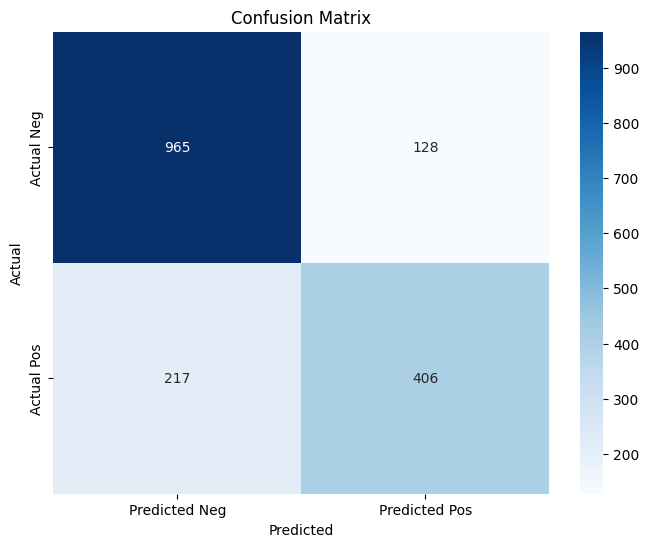

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns

# Define a threshold (e.g., mean of actual values)
threshold = np.mean(actual_rescaled)

# Generate binary labels based on the threshold
y_true = (actual_rescaled > threshold).astype(int)
y_pred = (predictions_rescaled > threshold).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate accuracy, error rate, and F1 score
accuracy = accuracy_score(y_true, y_pred)
error_rate = 1 - accuracy
f1 = f1_score(y_true, y_pred)

# Display results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Error Rate: {error_rate:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Neg', 'Predicted Pos'], yticklabels=['Actual Neg', 'Actual Pos'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
